In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def df_plot_cdf(data, colname, **kwargs):
    df = pd.DataFrame()
    df['counts'] = data.groupby(colname)[colname].count()
    df['cumsum'] = df['counts'].cumsum()
    df['cdf'] = df['cumsum']/float(df['counts'].sum())
    df['cdf'].plot(**kwargs)

# Priority Thread Scheduling

In [3]:
def plot_load_cdfs_sched(df):
    for m in df['mean_arrival_time'].unique():
        data = df[df['mean_arrival_time'] == m]
        df_plot_cdf(data[data['context'] == 0], 'resp_time', label='{}-C0'.format(m))
        df_plot_cdf(data[data['context'] == 1], 'resp_time', label='{}-C1'.format(m))
        print 'Num Requests @ mean_arrival_time {} cycles = {}'.format(m, len(data))

In [10]:
# If the number of responses is less than the number of
# requests that were sent then need to pad the data with
# infinite response times.
def pad_resp_df_sched(resp_df, req_df):
    for m in req_df['mean_arrival_time'].unique():
        # extract all data for this load
        req_load_df = req_df[req_df['mean_arrival_time'] == m]
        resp_load_df = resp_df[resp_df['mean_arrival_time'] == m]
        for c in [0, 1]:
            # extract all data for this context at this load
            req_context_df = req_load_df[req_load_df['context'] == c]
            resp_context_df = resp_load_df[resp_load_df['context'] == c]
            # add dummy rows with infinite resp time if needed
            if len(resp_context_df) < len(req_context_df):
                dummy_row = resp_context_df.head(1).copy()
                dummy_row['resp_time'] = 1e100
                dummy_rows = pd.concat([dummy_row]*(len(req_context_df) - len(resp_context_df)), ignore_index=True)
                resp_df = pd.concat([resp_df, dummy_rows], ignore_index=True)
            elif len(resp_context_df) > len(req_context_df):
                print "WARNING: more responses ({}) received than requests sent ({})! m={}, c={}".format(len(resp_context_df), len(req_context_df), m, c)
    return resp_df

In [22]:
def process_resp_time_sched(resp_df, req_df):
    # compute load
    resp_df['load'] = 1e3/(resp_df['mean_arrival_time']/3.2) # MRPS
    # convert resp_time from cycles to us
    resp_df['resp_time'] /= 3.2e3
    # compute and return tail latency
    resp_df = pad_resp_df_sched(resp_df, req_df)
    c0_tail = resp_df[resp_df['context'] == 0].groupby('load')['resp_time'].quantile(0.99)
    c1_tail = resp_df[resp_df['context'] == 1].groupby('load')['resp_time'].quantile(0.99)
    return c0_tail, c1_tail

In [80]:
# resdir = 'results-workload/2020-08-07--23-00-55-lnic-evaluation/switch0' # goarse-grained
resdir = 'results-workload/2020-08-09--01-11-27-lnic-evaluation/switch0' # fine-grained
lnic_sched_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
lnic_sched_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
lnic_sched_tail_c0, lnic_sched_tail_c1 = process_resp_time_sched(lnic_sched_stats, lnic_sched_req_stats)

In [81]:
# resdir = 'results-workload/2020-08-07--23-25-24-lnic-evaluation/switch0' # coarse-grained
resdir = 'results-workload/2020-08-09--00-47-51-lnic-evaluation/switch0' # fine-grained
timer_sched_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
timer_sched_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
timer_sched_tail_c0, timer_sched_tail_c1 = process_resp_time_sched(timer_sched_stats, timer_sched_req_stats)

<IPython.core.display.Javascript object>


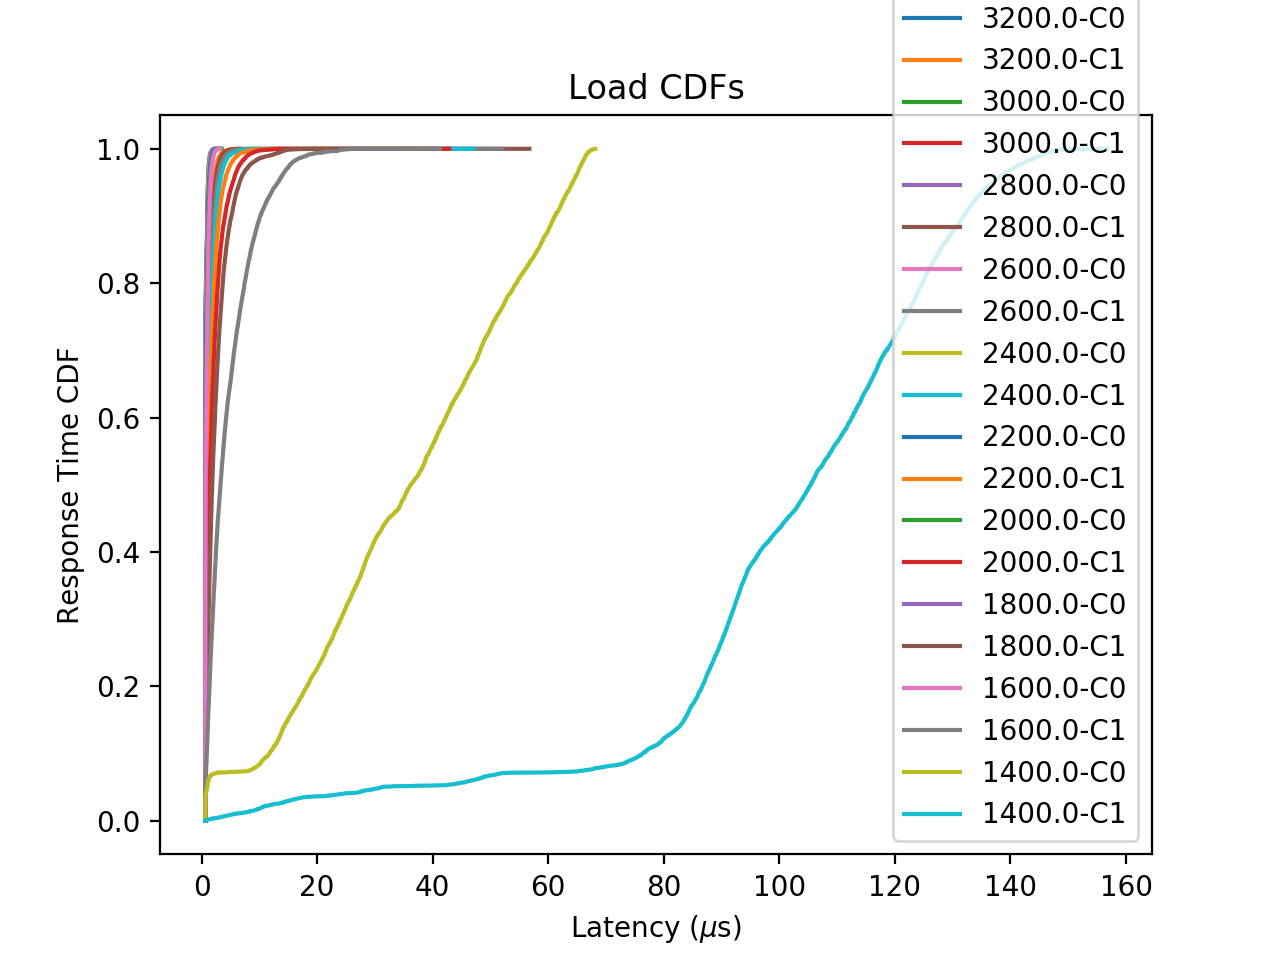

Num Requests @ mean_arrival_time 3200.0 cycles = 20000
Num Requests @ mean_arrival_time 3000.0 cycles = 20000
Num Requests @ mean_arrival_time 2800.0 cycles = 20000
Num Requests @ mean_arrival_time 2600.0 cycles = 20000
Num Requests @ mean_arrival_time 2400.0 cycles = 20000
Num Requests @ mean_arrival_time 2200.0 cycles = 20000
Num Requests @ mean_arrival_time 2000.0 cycles = 20000
Num Requests @ mean_arrival_time 1800.0 cycles = 20000
Num Requests @ mean_arrival_time 1600.0 cycles = 20000
Num Requests @ mean_arrival_time 1400.0 cycles = 17553


In [82]:
# Plot response time CDF for each load
plt.figure()
plot_load_cdfs_sched(lnic_sched_stats)
plt.title('Load CDFs')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


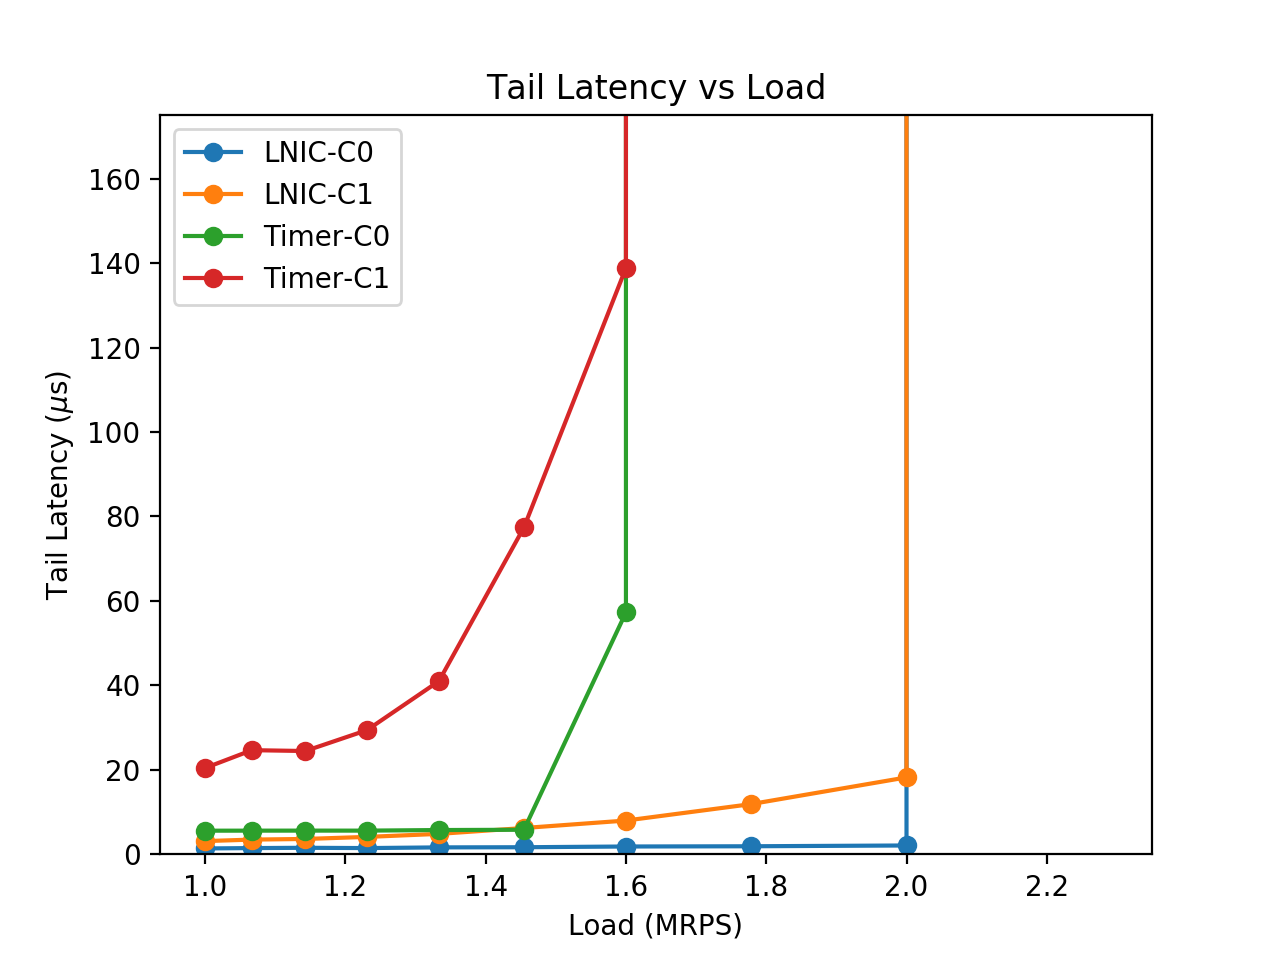

In [83]:
# Plot tail latency vs load
plt.figure()
lnic_sched_tail_c0.plot(marker='o', label='LNIC-C0')
lnic_sched_tail_c1.plot(marker='o', label='LNIC-C1')
timer_sched_tail_c0.plot(marker='o', label='Timer-C0')
timer_sched_tail_c1.plot(marker='o', label='Timer-C1')
plt.title('Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 175])
plt.show()

#### Notes:
* If the NIC was smarter about allocating buffer space for each context then the high priority (Context 0) thread would probably be able to achieve higher throughput for the LNIC-driven approach. Right now, msgs are dropped for both contexts when queues fill up. Really, only the C1 queue is filling up so only those msgs should be dropped.
* A pretty easy fix for this would be to only allow each context to use a max number of buffers in the reassembly module.

# Bounded Processing Time

In [97]:
# resdir = 'results-workload/2020-08-07--23-41-53-lnic-evaluation/switch0' # coarse-grained
resdir = 'results-workload/2020-08-09--01-42-09-lnic-evaluation/switch0' # fine-grained
bounded_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
bounded_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
bounded_tail_c0, bounded_tail_c1 = process_resp_time_sched(bounded_stats, bounded_req_stats)

In [93]:
# resdir = 'results-workload/2020-08-07--23-50-45-lnic-evaluation/switch0' # coarse-grained
resdir = 'results-workload/2020-08-09--01-33-54-lnic-evaluation/switch0' # fine-grained
unbounded_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
unbounded_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
unbounded_tail_c0, unbounded_tail_c1 = process_resp_time_sched(unbounded_stats, unbounded_req_stats)

<IPython.core.display.Javascript object>


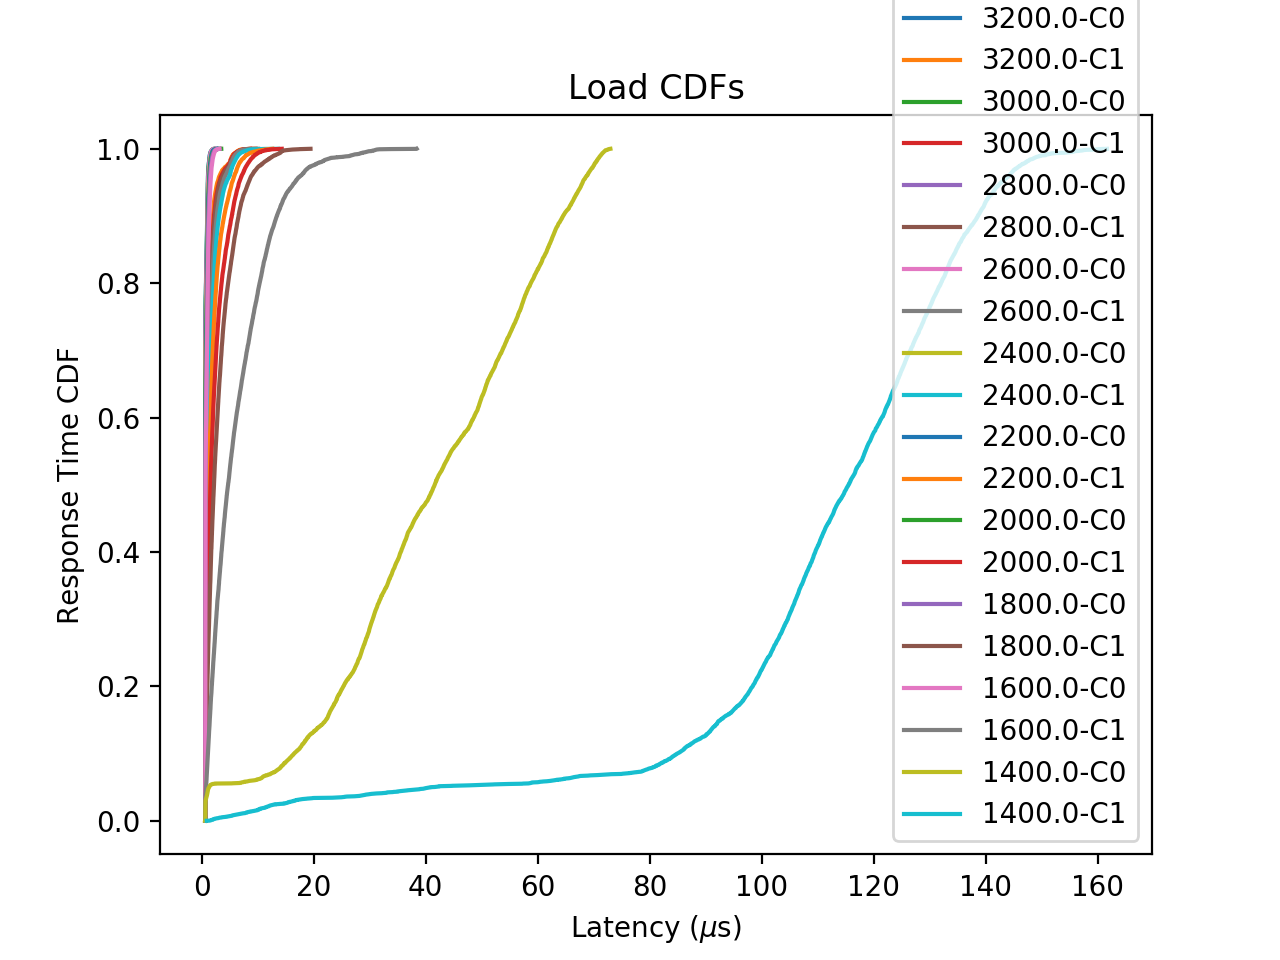

Num Requests @ mean_arrival_time 3200.0 cycles = 20000
Num Requests @ mean_arrival_time 3000.0 cycles = 20000
Num Requests @ mean_arrival_time 2800.0 cycles = 20000
Num Requests @ mean_arrival_time 2600.0 cycles = 20000
Num Requests @ mean_arrival_time 2400.0 cycles = 20000
Num Requests @ mean_arrival_time 2200.0 cycles = 20000
Num Requests @ mean_arrival_time 2000.0 cycles = 20000
Num Requests @ mean_arrival_time 1800.0 cycles = 20000
Num Requests @ mean_arrival_time 1600.0 cycles = 20000
Num Requests @ mean_arrival_time 1400.0 cycles = 16805


In [98]:
# Plot response time CDF for each load
plt.figure()
plot_load_cdfs_sched(bounded_stats)
plt.title('Load CDFs')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


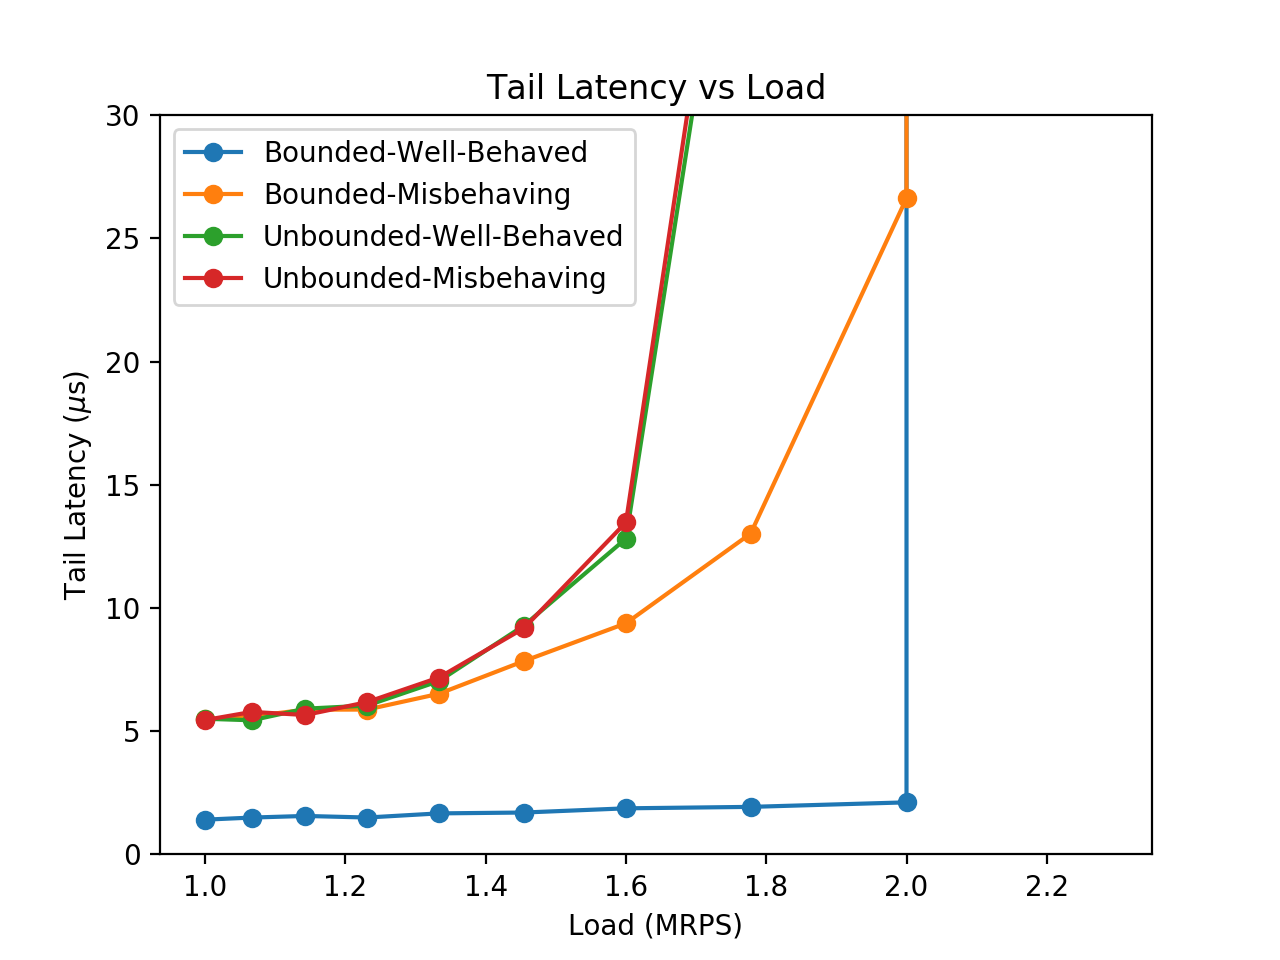

In [99]:
# Plot tail latency vs load
plt.figure()
bounded_tail_c0.plot(marker='o', label='Bounded-Well-Behaved')
bounded_tail_c1.plot(marker='o', label='Bounded-Misbehaving')
unbounded_tail_c0.plot(marker='o', label='Unbounded-Well-Behaved')
unbounded_tail_c1.plot(marker='o', label='Unbounded-Misbehaving')
plt.title('Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 30])
plt.show()

# Load Balancing

In [46]:
def plot_load_cdfs_lb(df):
    for m in df['mean_arrival_time'].unique():
        data = df[df['mean_arrival_time'] == m]
        df_plot_cdf(data, 'resp_time', label='{}'.format(m))
        print 'Num Requests @ mean_arrival_time {} cycles = {}'.format(m, len(data))

In [47]:
# If the number of responses is less than the number of
# requests that were sent then need to pad the data with
# infinite response times.
def pad_resp_df_lb(resp_df, req_df):
    for m in req_df['mean_arrival_time'].unique():
        # extract all data for this load
        req_load_df = req_df[req_df['mean_arrival_time'] == m]
        resp_load_df = resp_df[resp_df['mean_arrival_time'] == m]
        # add dummy rows with infinite resp time if needed
        if len(resp_load_df) < len(req_load_df):
            dummy_row = resp_load_df.head(1).copy()
            dummy_row['resp_time'] = 1e100
            dummy_rows = pd.concat([dummy_row]*(len(req_load_df) - len(resp_load_df)), ignore_index=True)
            resp_df = pd.concat([resp_df, dummy_rows], ignore_index=True)
        elif len(resp_load_df) > len(req_load_df):
            print "WARNING: more responses ({}) received than requests sent ({})! m={}".format(len(resp_load_df), len(req_load_df), m)
    return resp_df

In [48]:
def process_resp_time_lb(resp_df, req_df):
    # compute load
    resp_df['load'] = 1e3/(resp_df['mean_arrival_time']/3.2) # MRPS
    # convert resp_time from cycles to us
    resp_df['resp_time'] /= 3.2e3
    # compute and return tail latency
    resp_df = pad_resp_df_lb(resp_df, req_df)
    tail = resp_df.groupby('load')['resp_time'].quantile(0.99)
    return tail

In [100]:
# resdir = 'results-workload/2020-08-08--00-40-06-lnic-evaluation/switch0' # coarse-grained
resdir = 'results-workload/2020-08-09--02-11-54-lnic-evaluation/switch0' # fine-grained
rss_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
rss_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
rss_tail = process_resp_time_lb(rss_stats, rss_req_stats)

In [104]:
# resdir = 'results-workload/2020-08-08--00-44-00-lnic-evaluation/switch0' # coarse-grained
resdir = 'results-workload/2020-08-09--02-17-40-lnic-evaluation/switch0' # fine-grained
jbsq_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
jbsq_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
jbsq_tail = process_resp_time_lb(jbsq_stats, jbsq_req_stats)

In [111]:
# resdir = 'results-workload/2020-08-08--00-48-38-lnic-evaluation/switch0' # coarse-grained
resdir = 'results-workload/2020-08-09--02-30-24-lnic-evaluation/switch0' # fine-grained
jbsq_pre_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
jbsq_pre_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
jbsq_pre_tail = process_resp_time_lb(jbsq_pre_stats, jbsq_pre_req_stats)

<IPython.core.display.Javascript object>


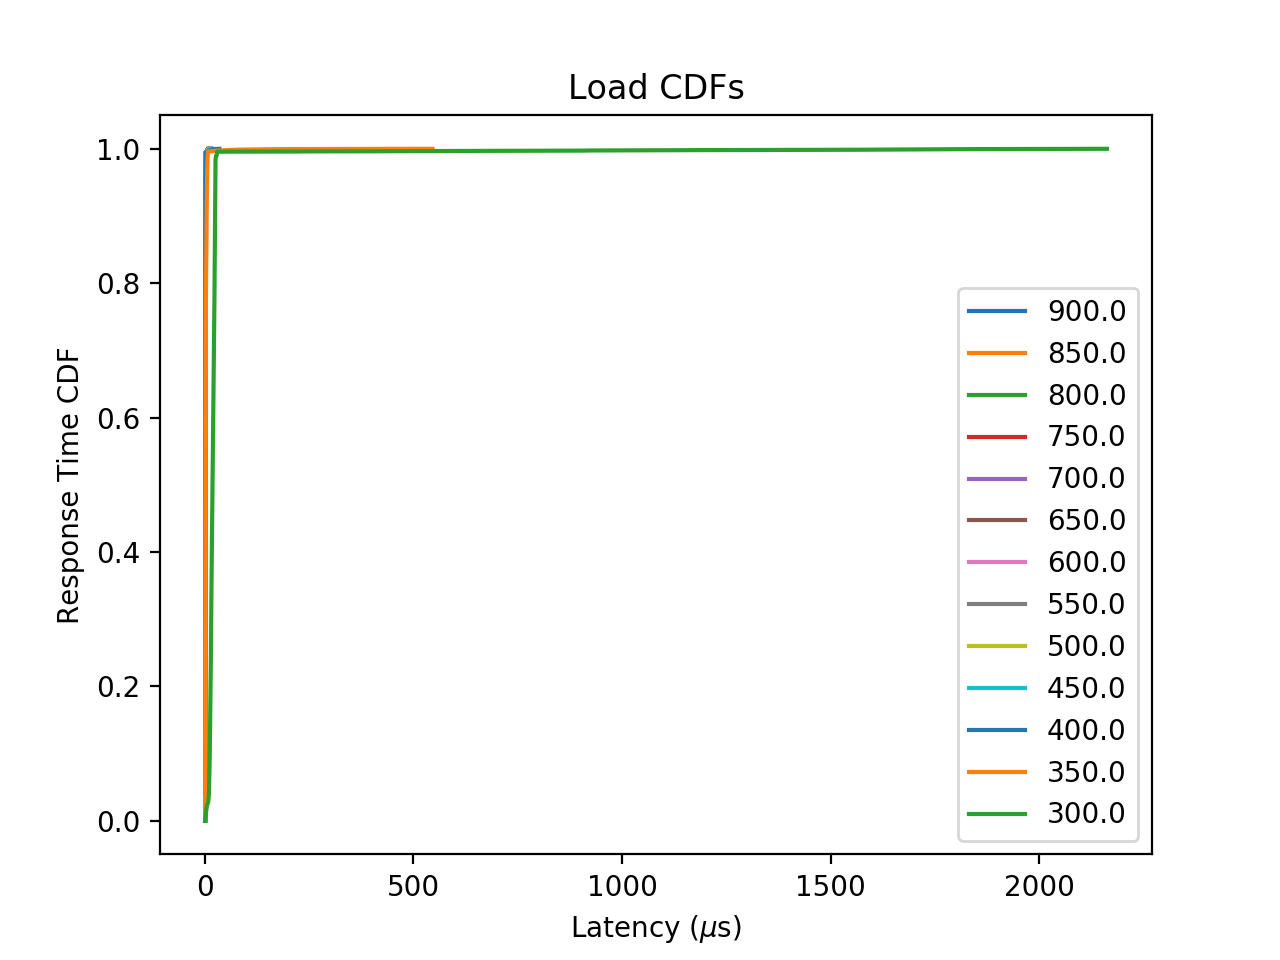

Num Requests @ mean_arrival_time 900.0 cycles = 20000
Num Requests @ mean_arrival_time 850.0 cycles = 20000
Num Requests @ mean_arrival_time 800.0 cycles = 20000
Num Requests @ mean_arrival_time 750.0 cycles = 20000
Num Requests @ mean_arrival_time 700.0 cycles = 20000
Num Requests @ mean_arrival_time 650.0 cycles = 20000
Num Requests @ mean_arrival_time 600.0 cycles = 20000
Num Requests @ mean_arrival_time 550.0 cycles = 20000
Num Requests @ mean_arrival_time 500.0 cycles = 20000
Num Requests @ mean_arrival_time 450.0 cycles = 20000
Num Requests @ mean_arrival_time 400.0 cycles = 20000
Num Requests @ mean_arrival_time 350.0 cycles = 20000
Num Requests @ mean_arrival_time 300.0 cycles = 18552


In [112]:
# Plot response time CDF for each load
plt.figure()
plot_load_cdfs_lb(jbsq_pre_stats)
plt.title('Load CDFs')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


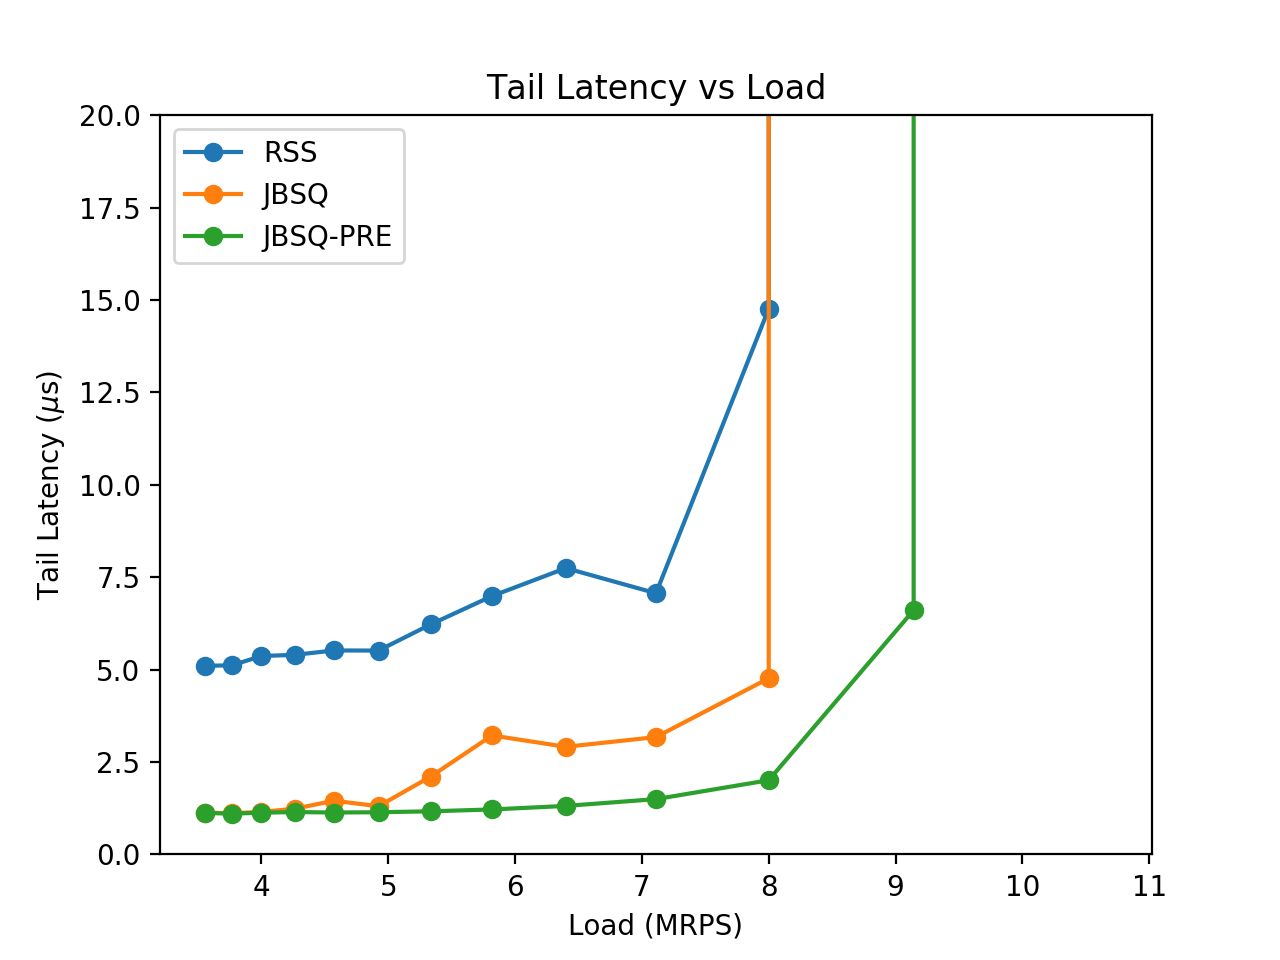

In [113]:
# Plot tail latency vs load
plt.figure()
rss_tail.plot(marker='o', label='RSS')
jbsq_tail.plot(marker='o', label='JBSQ')
jbsq_pre_tail.plot(marker='o', label='JBSQ-PRE')
plt.title('Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 20])
plt.show()